In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


sample_submission_v2.csv
test-jpg-v2
test-tif-v3
test_v2_file_mapping.csv
train-jpg
train-tif-v2
train_v2.csv



In [28]:
import os
import math
import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

In [29]:
filenames = os.listdir('../input/train-jpg')
df = pd.read_csv('../input/train_v2.csv')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
image_name    40479 non-null object
tags          40479 non-null object
dtypes: object(2)
memory usage: 632.6+ KB


In [31]:
df.describe()

,image_name,tags
count,40479,40479
unique,40479,449
top,train_29024,clear primary
freq,1,13636


In [32]:
df['tag_set'] = df['tags'].map(lambda s: set(s.split(' ')))

tags = set()
for t in df['tags']:
    s = set(t.split(' '))
    tags = tags | s

tag_list = list(tags)
tag_list.sort()
tag_columns = ['tag_' + t for t in tag_list]
for t in tag_list:
    df['tag_' + t] = df['tag_set'].map(lambda x: 1 if t in x else 0)

In [33]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 20 columns):
image_name               40479 non-null object
tags                     40479 non-null object
tag_set                  40479 non-null object
tag_agriculture          40479 non-null int64
tag_artisinal_mine       40479 non-null int64
tag_bare_ground          40479 non-null int64
tag_blooming             40479 non-null int64
tag_blow_down            40479 non-null int64
tag_clear                40479 non-null int64
tag_cloudy               40479 non-null int64
tag_conventional_mine    40479 non-null int64
tag_cultivation          40479 non-null int64
tag_habitation           40479 non-null int64
tag_haze                 40479 non-null int64
tag_partly_cloudy        40479 non-null int64
tag_primary              40479 non-null int64
tag_road                 40479 non-null int64
tag_selective_logging    40479 non-null int64
tag_slash_burn           40479 non-null int64
tag_water     

,tag_agriculture,tag_artisinal_mine,tag_bare_ground,tag_blooming,tag_blow_down,tag_clear,tag_cloudy,tag_conventional_mine,tag_cultivation,tag_habitation,tag_haze,tag_partly_cloudy,tag_primary,tag_road,tag_selective_logging,tag_slash_burn,tag_water
count,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000
mean,0.304232,0.008375,0.021295,0.008202,0.002421,0.702364,0.051607,0.002470,0.110601,0.090417,0.066627,0.179377,0.926727,0.199387,0.008399,0.005163,0.183083
std,0.460087,0.091131,0.144368,0.090193,0.049145,0.457224,0.221235,0.049642,0.313641,0.286782,0.249378,0.383672,0.260587,0.399545,0.091264,0.071670,0.386739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
df.head()

,image_name,tags,tag_set,tag_agriculture,tag_artisinal_mine,tag_bare_ground,tag_blooming,tag_blow_down,tag_clear,tag_cloudy,tag_conventional_mine,tag_cultivation,tag_habitation,tag_haze,tag_partly_cloudy,tag_primary,tag_road,tag_selective_logging,tag_slash_burn,tag_water
0,train_0,haze primary,"{haze, primary}",0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,"{water, agriculture, primary, clear}",1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,"{primary, clear}",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,"{primary, clear}",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,"{road, agriculture, clear, habitation, primary}",1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [35]:
df[tag_columns].sum()

tag_agriculture          12315
tag_artisinal_mine         339
tag_bare_ground            862
tag_blooming               332
tag_blow_down               98
tag_clear                28431
tag_cloudy                2089
tag_conventional_mine      100
tag_cultivation           4477
tag_habitation            3660
tag_haze                  2697
tag_partly_cloudy         7261
tag_primary              37513
tag_road                  8071
tag_selective_logging      340
tag_slash_burn             209
tag_water                 7411
dtype: int64

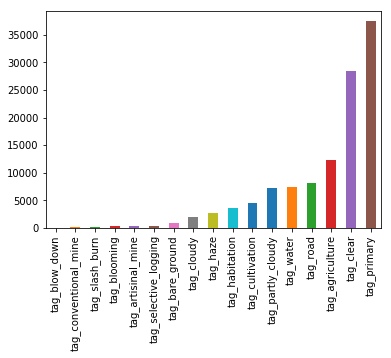

In [36]:
df[tag_columns].sum().sort_values().plot.bar()

In [37]:
tags_count = df.groupby('tags').count().sort_values(by='image_name', ascending=False)['image_name']
print('There are {} unique tag combinations'.format(len(tags_count)))
print()
print(tags_count)

There are 449 unique tag combinations

tags
clear primary                                                                13636
partly_cloudy primary                                                         3630
cloudy                                                                        2089
clear primary water                                                           1850
agriculture clear primary road                                                1680
agriculture clear primary                                                     1626
haze primary                                                                  1471
agriculture clear cultivation primary                                         1170
agriculture clear habitation primary road                                     1125
agriculture clear primary water                                                712
agriculture partly_cloudy primary                                              692
partly_cloudy primary water                

In [38]:
from textwrap import wrap

def display(images, cols=None, maxcols=10, width=14, titles=None):
    if cols is None:
        cols = len(images)
    n_cols = cols if cols < maxcols else maxcols
    plt.rc('axes', grid=False)
    fig1 = plt.figure(1, (width, width * math.ceil(len(images)/n_cols)))
    grid1 = ImageGrid(
                fig1,
                111,
                nrows_ncols=(math.ceil(len(images)/n_cols), n_cols),
                axes_pad=(0.1, 0.6)
            )

    for index, img in enumerate(images):
        grid1[index].grid = False
        if titles is not None:
            grid1[index].set_title('\n'.join(wrap(titles[index], width=25)))
        if len(img.shape) == 2:
            grid1[index].imshow(img, cmap='gray')
        else:
            grid1[index].imshow(img)

In [39]:
def load_image(filename, resize=True, folder='train-jpg'):
    img = mpimg.imread('../input/{}/{}.jpg'.format(folder, filename))
    if resize:
        img = cv2.resize(img, (64, 64))
    return np.array(img)

def mean_normalize(img):
    return (img - img.mean()) / (img.max() - img.min())

def normalize(img):
    return img / 127.5 - 1

(64, 64, 4)


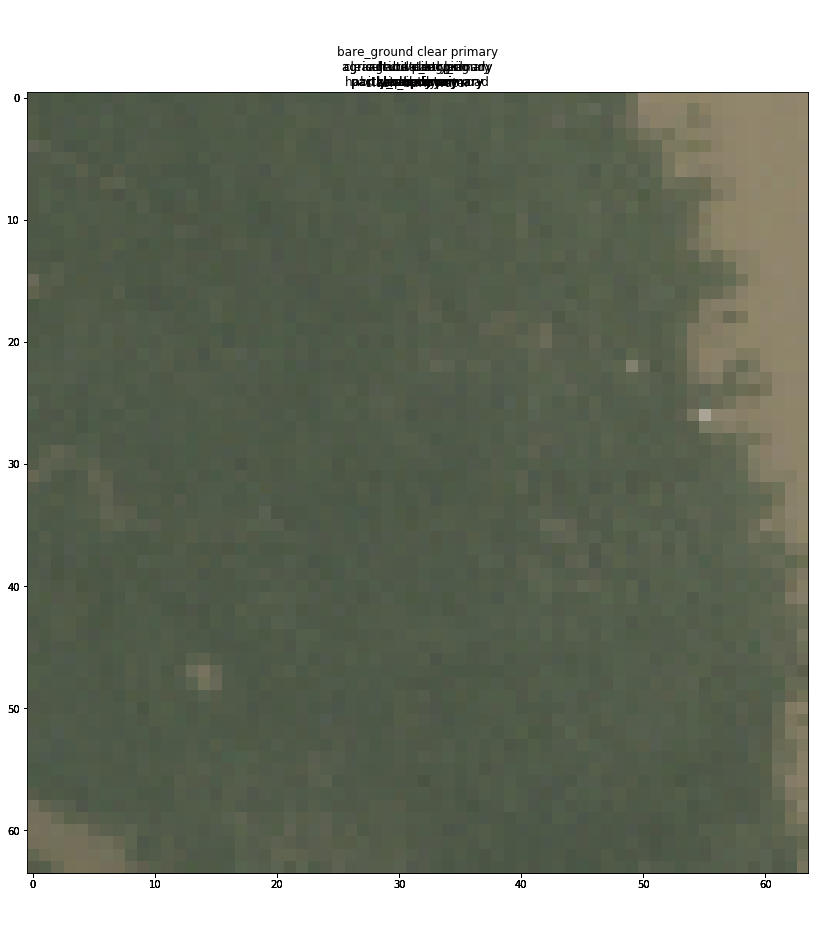

In [40]:
samples = df.sample(16)
sample_images = [load_image(fn) for fn in samples['image_name']]
INPUT_SHAPE = sample_images[0].shape
print(INPUT_SHAPE)
display(
    sample_images,
    cols=4,
    titles=[t for t in samples['tags']]
)

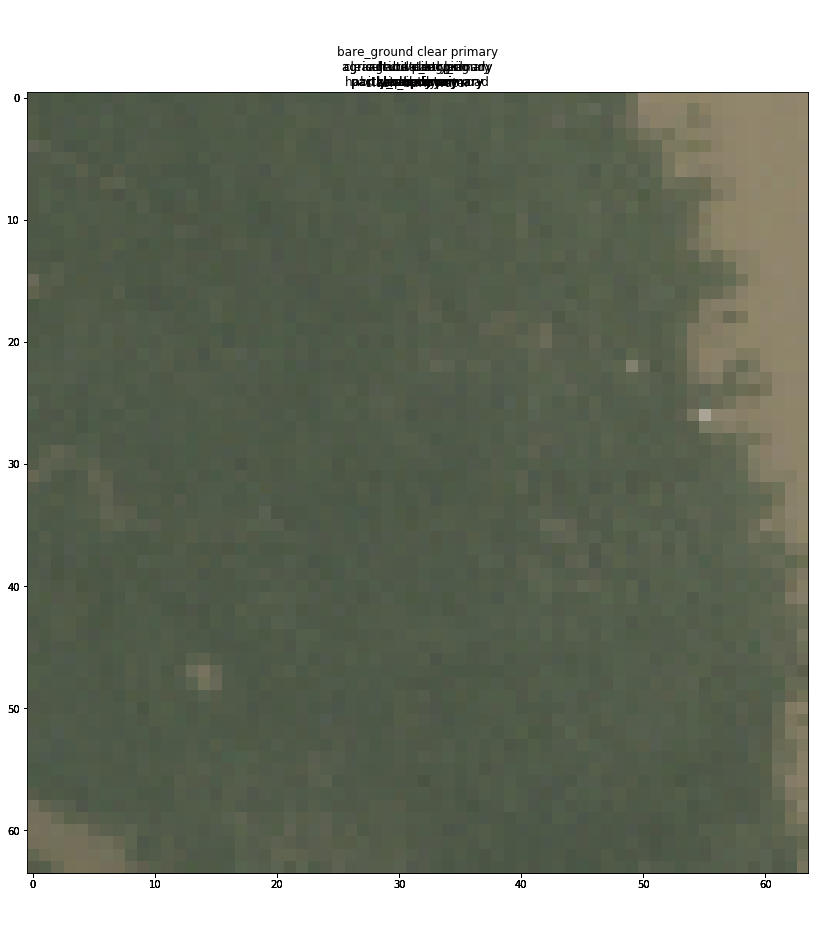

In [41]:
def preprocess(img):
    img = normalize(img)
    return img

display(
    [(127.5 * (preprocess(img) + 1)).astype(np.uint8) for img in sample_images],
    cols=4,
    titles=[t for t in samples['tags']]
)

# Learn

In [42]:
df_train = df

In [43]:
X = df_train['image_name'].values
y = df_train[tag_columns].values

n_features = 1
n_classes = y.shape[1]

X, y = shuffle(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

print('We\'ve got {} feature rows and {} labels'.format(len(X_train), len(y_train)))
print('Each row has {} features'.format(n_features))
print('and we have {} classes'.format(n_classes))
assert(len(y_train) == len(X_train))
print('We use {} rows for training and {} rows for validation'.format(len(X_train), len(X_valid)))
print('Each image has the shape:', INPUT_SHAPE)
print('So far, so good')

We've got 36431 feature rows and 36431 labels
Each row has 1 features
and we have 17 classes
We use 36431 rows for training and 4048 rows for validation
Each image has the shape: (64, 64, 4)
So far, so good


In [44]:
print('Memory usage (train) kB', X_train.nbytes//(1024))
print('Memory usage (valid) kB', X_valid.nbytes//(1024))

Memory usage (train) kB 284
Memory usage (valid) kB 31


In [45]:
def generator(X, y, batch_size=32):
    X_copy, y_copy = X, y
    while True:
        for i in range(0, len(X_copy), batch_size):
            X_result, y_result = [], []
            for x, y in zip(X_copy[i:i+batch_size], y_copy[i:i+batch_size]):
                rx, ry = [load_image(x)], [y]
                rx = np.array([preprocess(x) for x in rx])
                ry = np.array(ry)
                X_result.append(rx)
                y_result.append(ry)
            X_result, y_result = np.concatenate(X_result), np.concatenate(y_result)
            yield shuffle(X_result, y_result)
        X_copy, y_copy = shuffle(X_copy, y_copy)

In [46]:
from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

# define the model

model = Sequential()

model.add(Conv2D(48, (8, 8), strides=(2, 2), input_shape=INPUT_SHAPE, activation='elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (8, 8), strides=(2, 2), activation='elu'))
model.add(BatchNormalization())

model.add(Conv2D(96, (5, 5), strides=(2, 2), activation='elu'))
model.add(BatchNormalization())

model.add(Conv2D(96, (3, 3), activation='elu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='sigmoid'))

    
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[fbeta, 'accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 29, 29, 48)        12336     
_________________________________________________________________
batch_normalization_7 (Batch (None, 29, 29, 48)        192       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        196672    
_________________________________________________________________
batch_normalization_8 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 96)          153696    
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 4, 96)          384       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 96)          83040     
__________

In [47]:
EPOCHS = 3
BATCH = 32
PER_EPOCH = 256

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

filepath="weights-improvement-{epoch:02d}-{val_fbeta:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_fbeta', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(
    generator(X_train, y_train, batch_size=BATCH),
    steps_per_epoch=PER_EPOCH,
    epochs=EPOCHS,
    validation_data=generator(X_valid, y_valid, batch_size=BATCH),
    validation_steps=len(y_valid)//(4*BATCH),
    callbacks=callbacks_list
)

Epoch 1/3
256/256 [==============================] - 53s 206ms/step - loss: 0.4385 - fbeta: 0.6512 - acc: 0.8379 - val_loss: 0.2846 - val_fbeta: 0.6352 - val_acc: 0.8922

Epoch 00001: val_fbeta improved from -inf to 0.63521, saving model to weights-improvement-01-0.635.hdf5
Epoch 2/3
256/256 [==============================] - 50s 197ms/step - loss: 0.2103 - fbeta: 0.6777 - acc: 0.9191 - val_loss: 0.2628 - val_fbeta: 0.5954 - val_acc: 0.8754

Epoch 00002: val_fbeta did not improve from 0.63521
Epoch 3/3
256/256 [==============================] - 51s 198ms/step - loss: 0.1960 - fbeta: 0.6957 - acc: 0.9216 - val_loss: 0.1999 - val_fbeta: 0.7223 - val_acc: 0.9223

Epoch 00003: val_fbeta improved from 0.63521 to 0.72228, saving model to weights-improvement-03-0.722.hdf5
